In [1]:
!pip install moviepy
!pip install librosa
!pip install noisereduce
!pip install transformers


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from moviepy.editor import VideoFileClip
import librosa
from transformers import DistilBertTokenizer , DistilBertModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModel
from transformers import RobertaTokenizer, RobertaModel
import noisereduce as nr
from scipy import signal


Uploading the dataset


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ziya07/multimodal-emotion-recognition-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.73G/4.73G [01:14<00:00, 68.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ziya07/multimodal-emotion-recognition-dataset/versions/2


In [7]:
import os
dataset_path = "/root/.cache/kagglehub/datasets/ziya07/multimodal-emotion-recognition-dataset/versions/2"
print(os.listdir(dataset_path))


['archive (19)', 'archive (18)']


In [8]:
import pandas as pd
csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
if csv_files:
    df = pd.read_csv(os.path.join(dataset_path, csv_files[0]))
    print(df.head())
else:
    print("No CSV file found. Look for other data formats or folders.")


No CSV file found. Look for other data formats or folders.


In [9]:
subfolders = ['archive (19)', 'archive (18)']
for folder in subfolders:
    folder_path = os.path.join(dataset_path, folder)
    print(f"Files in {folder}: {os.listdir(folder_path)}")


Files in archive (19): ['test', 'train']
Files in archive (18): ['Multimodel_Dataset']


In [10]:
for folder in subfolders:
    folder_path = os.path.join(dataset_path, folder)
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    if csv_files:
        df = pd.read_csv(os.path.join(folder_path, csv_files[0]))
        print(f"Loaded {csv_files[0]} from {folder}")
        print(df.head())
    else:
        print(f"No CSV file found in {folder}")


No CSV file found in archive (19)
No CSV file found in archive (18)


In [11]:
# Check inside 'archive (19)/train', 'archive (19)/test', etc.
for subfolder in ['archive (19)', 'archive (18)']:
    folder_path = os.path.join(dataset_path, subfolder)
    inner_folders = os.listdir(folder_path)
    print(f"Files/folders inside {subfolder}:", inner_folders)
    for inner in inner_folders:
        inner_path = os.path.join(folder_path, inner)
        print(f"Contents of {subfolder}/{inner}:", os.listdir(inner_path))


Files/folders inside archive (19): ['test', 'train']
Contents of archive (19)/test: ['surprise', 'happy', 'fear', 'neutral', 'sad', 'disgust', 'angry']
Contents of archive (19)/train: ['surprise', 'happy', 'fear', 'neutral', 'sad', 'disgust', 'angry']
Files/folders inside archive (18): ['Multimodel_Dataset']
Contents of archive (18)/Multimodel_Dataset: ['Video_Dataset', 'EEG Data', 'Audio_Dataset']


In [12]:
import os
import pandas as pd

split = 'train'
root_folder = os.path.join(dataset_path, 'archive (19)', split)
labels = os.listdir(root_folder)
samples = []

for label in labels:
    label_folder = os.path.join(root_folder, label)
    for f in os.listdir(label_folder):
        sample_path = os.path.join(label_folder, f)
        samples.append({'file_path': sample_path, 'label': label})

df = pd.DataFrame(samples)
csv_out_path = f"{split}_metadata.csv"
df.to_csv(csv_out_path, index=False)
print(df.head())


                                           file_path     label
0  /root/.cache/kagglehub/datasets/ziya07/multimo...  surprise
1  /root/.cache/kagglehub/datasets/ziya07/multimo...  surprise
2  /root/.cache/kagglehub/datasets/ziya07/multimo...  surprise
3  /root/.cache/kagglehub/datasets/ziya07/multimo...  surprise
4  /root/.cache/kagglehub/datasets/ziya07/multimo...  surprise


In [13]:
print(df['file_path'].map(lambda x: os.path.splitext(x)[1]).value_counts())


file_path
.jpg    28709
Name: count, dtype: int64


audio feature extraction

In [14]:
import librosa
import numpy as np
from tqdm import tqdm

def extract_mfcc(file_path, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = np.mean(mfcc, axis=1)
    return mfcc

df['mfcc'] = [extract_mfcc(fp) for fp in tqdm(df['file_path'])]
print(df.head())


  0%|          | 0/28709 [00:00<?, ?it/s]/tmp/ipython-input-3169429604.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  0%|          | 0/28709 [00:07<?, ?it/s]


NoBackendError: 

In [15]:
import os

print(df['file_path'].apply(lambda x: os.path.splitext(x)[1]).value_counts())


file_path
.jpg    28709
Name: count, dtype: int64


In [16]:
import cv2
import numpy as np
from tqdm import tqdm

def preprocess_image(image_path, size=(64, 64)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, size)
    return img.flatten()

# Apply to all rows
df['img_features'] = [preprocess_image(fp) for fp in tqdm(df['file_path'])]


100%|██████████| 28709/28709 [00:04<00:00, 6300.55it/s]


In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = np.stack(df['img_features'].values)
le = LabelEncoder()
y = le.fit_transform(df['label'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
print("Validation accuracy:", clf.score(X_val, y_val))


KeyboardInterrupt: 

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

dataset_dir = "/root/.cache/kagglehub/datasets/ziya07/multimodal-emotion-recognition-dataset/versions/2/archive (19)/train"

# Image Data Generators for train and validation with 20% split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Simple CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen
)



Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 179s 246ms/step - accuracy: 0.2534 - loss: 1.8098 - val_accuracy: 0.3665 - val_loss: 1.6062
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 182s 253ms/step - accuracy: 0.3777 - loss: 1.5909 - val_accuracy: 0.4348 - val_loss: 1.4581
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 175s 243ms/step - accuracy: 0.4395 - loss: 1.4521 - val_accuracy: 0.4740 - val_loss: 1.3820
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 174s 242ms/step - accuracy: 0.4742 - loss: 1.3725 - val_accuracy: 0.4891 - val_loss: 1.3492
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 181s 252ms/step - accuracy: 0.4944 - loss: 1.3118 - val_accuracy: 0.5097 - val_loss: 1.2881
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 181s 252ms/step - accuracy: 0.5193 - loss: 1.2699 - val_accuracy: 0.5112 - val_loss: 1.2800
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 174s 243ms/step - accuracy: 0.5315 - loss: 1.2237 - val_accuracy: 0.5189 - val_loss: 1.2459
Epoch 8/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 171s 239ms/step - accuracy: 0.5508 - loss: 1.18

evaluating model performance

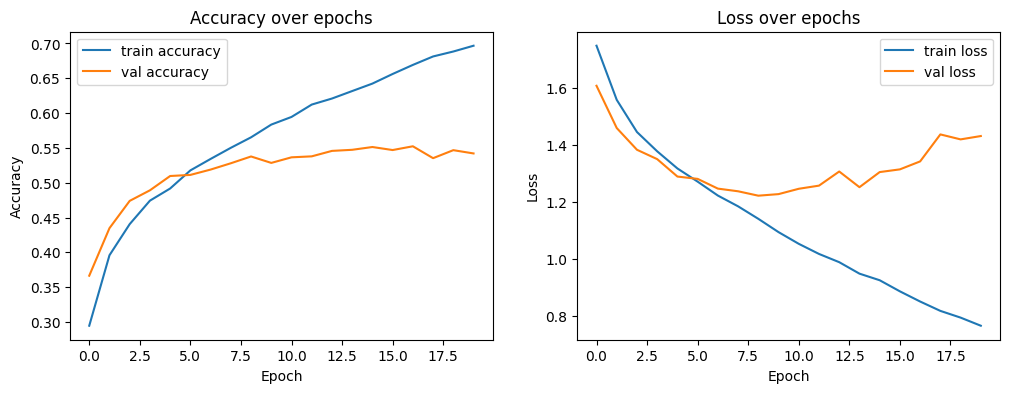

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [22]:
model.save("emotion_cnn_model.keras")


In [23]:
from tensorflow.keras.models import load_model

model = load_model("emotion_cnn_model.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_emotion(img_path, model, class_indices):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(64, 64))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    inv_map = {v: k for k, v in class_indices.items()}
    return inv_map[np.argmax(preds)]

# Example usage
prediction = predict_emotion("test_image.jpg", model, train_gen.class_indices)
print("Predicted Emotion:", prediction)


FileNotFoundError: [Errno 2] No such file or directory: 'test_image.jpg'

In [ ]:
import gradio as gr
from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image # Not needed with gr.Image
import numpy as np
from PIL import Image # Import PIL for image processing

# Load your saved model
# The UserWarning about the optimizer is common when loading models trained with a different Keras version
# or optimizer state. It might not always affect the model's performance for inference.
# You can ignore it for now unless you see issues with predictions.
model = load_model("emotion_cnn_model.keras")

# Class index mapping (use the same mapping as your training generator)
# Ensure this mapping is correct based on your training data and how the model was trained.
# You might need to get this from your train_gen object or a saved mapping.
class_indices = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
inv_map = {v: k for k, v in class_indices.items()}

def predict_emotion(img: Image.Image):
    # Ensure the input is a PIL Image object
    if not isinstance(img, Image.Image):
        raise TypeError("Input must be a PIL Image object")

    img = img.convert("L")  # convert to grayscale
    img = img.resize((64, 64))
    x = np.array(img) / 255.0
    x = np.expand_dims(x, axis=(0, -1))  # add batch and channel dimensions for CNN input
    preds = model.predict(x)
    pred_label = inv_map[np.argmax(preds)]
    confidence = np.max(preds)
    return f"{pred_label} ({confidence:.2f})"

# Create Gradio interface using the updated syntax for inputs
iface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Image(type="pil", label="Upload Facial Image"), # Use gr.Image with type="pil"
    outputs="text",
    title="Emotion Recognition from Facial Image",
    description="Upload an image of a face, and the model predicts the emotion."
)

# Launch the Gradio interface
iface.launch(debug=True) # Set debug=True for more detailed logs

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ac87ce054921601988.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
